<a href="https://colab.research.google.com/github/leonyangucl/2023fyp/blob/main/PD_inpainting11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data pre-processing part

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
import nibabel as nib
from tqdm import tqdm
import os
import math


from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

##Read the data

Data shape example:

In [ ]:

def plot_intensity_histogram(data, n_slices=10):
    num_slices = data.shape[2]

    slice_indices = np.random.choice(range(num_slices), size=n_slices, replace=False)

    fig, axs = plt.subplots(n_slices, 1, figsize=(10, 2*n_slices))

    for i, idx in enumerate(slice_indices):
        axs[i].hist(data[..., idx].ravel(), bins=256, color='blue', alpha=0.7)
        axs[i].set_title('Slice')
        axs[i].set_xlabel('Intensity')
        axs[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


In [3]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

all_folder_names = os.listdir(dir_path)


train_folders, test_folders = train_test_split(all_folder_names, test_size=0.2)

def process_folders(folder_list):
    all_data = []
    all_masks = []
    for i, folder_name in enumerate(folder_list):
        file_path = os.path.join(dir_path, folder_name, 'ASL', 'PD_cal.nii.gz')
        mask_path = os.path.join(dir_path, folder_name, 'T1', 'ROI_regi.nii.gz')  # Define the mask path
        if os.path.exists(file_path) and os.path.exists(mask_path):  # Check if both data and mask exist
            img = nib.load(file_path)
            mask = nib.load(mask_path)
            data = img.get_fdata()
            mask_data = mask.get_fdata()
            # Calculate the mean of PD images
            mean_data = np.mean(data, axis=3)

            mean_data_1 = mean_data
            mask_data_1 = mask_data

            #volume-wise normalisation
            lower, upper = np.percentile(mean_data_1, [1, 99])
            norm_data = np.clip(mean_data_1, lower, upper)
            norm_data = (norm_data - lower) / (upper - lower)

            # if i % 100 == 0:
            #     plot_intensity_histogram(mean_data_1)

            for j in range(20):
                slice_data = norm_data[..., j]
                slice_mask = mask_data_1[..., j]
                slice_mask = np.where(slice_mask == 0, 1, 0) #change the value of the mask
                # normalization for each slice
                # min_val = np.min(slice_data)
                # max_val = np.max(slice_data)
                # norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
                all_data.append(slice_data)
                all_masks.append(slice_mask)  # Add the slice of the mask to the list

    dataset = np.stack(all_data)
    maskset = np.stack(all_masks)
    return dataset, maskset


data_set, train_masks = process_folders(all_folder_names)
print(train_masks.shape)
# train_masks = np.expand_dims(train_masks, axis=-1)
# print(train_masks.shape)

# def filter_full_one_masks(masks):
#     mask_sums = np.sum(masks.reshape(masks.shape[0], -1), axis=1)
#     return masks[mask_sums != masks.shape[1] * masks.shape[2]]

# train_masks = filter_full_one_masks(train_masks)
# print(train_masks.shape)

(1140, 80, 80)


In [4]:

num_slices, width, height = train_masks.shape

full_one_slices = np.sum(train_masks.reshape(num_slices, -1).sum(axis=1) == width * height)

print(f"There are {full_one_slices} fully-1 slices in train_masks.")


There are 578 fully-1 slices in train_masks.


In [4]:
def crop_images(data, masks, crop_size=(32, 32)):
    X_real, masks_real, X_real_whole = [], [], []
    half_size = crop_size[0] // 2, crop_size[1] // 2  # half size of the crop size

    for i in range(len(data)):
        img = data[i]
        mask = masks[i]

        # check if the mask is all ones
        if np.all(mask == 1):
            continue

        # find the coordinates of the region where mask equals to 0
        coords = np.where(mask == 0)
        min_y, max_y = np.min(coords[0]), np.max(coords[0])
        min_x, max_x = np.min(coords[1]), np.max(coords[1])

        # Check if the region is too large
        if max_y - min_y >= crop_size[0] or max_x - min_x >= crop_size[1]:
            continue

        # Otherwise, calculate the center of the region
        center_y, center_x = (min_y + max_y) // 2, (min_x + max_x) // 2

        # Calculate the top-left and bottom-right coordinates of the crop area
        start_y, end_y = max(0, center_y - half_size[0]), min(img.shape[0], center_y + half_size[0])
        start_x, end_x = max(0, center_x - half_size[1]), min(img.shape[1], center_x + half_size[1])

        # Crop the region from the image and mask
        cropped = img[start_y:end_y, start_x:end_x]
        cropped_mask = mask[start_y:end_y, start_x:end_x]

        # If the cropped region is smaller than the desired size, pad it with zeros
        if cropped.shape[0] < crop_size[0] or cropped.shape[1] < crop_size[1]:
            padded = np.zeros(crop_size)
            padded[:cropped.shape[0], :cropped.shape[1]] = cropped
            cropped = padded

            padded_mask = np.ones(crop_size)
            padded_mask[:cropped_mask.shape[0], :cropped_mask.shape[1]] = cropped_mask
            cropped_mask = padded_mask

        X_real.append(cropped)
        masks_real.append(cropped_mask)
        X_real_whole.append(img)

    return np.array(X_real), np.array(masks_real), np.array(X_real_whole)

X_real_train, masks_real_train, X_real_whole_train = crop_images(data_set, train_masks)






print('train data:', X_real_train.shape)
print('train masks:', masks_real_train.shape)
print('train whole data:', X_real_whole_train.shape)



train data: (519, 32, 32)
train masks: (519, 32, 32)
train whole data: (519, 80, 80)


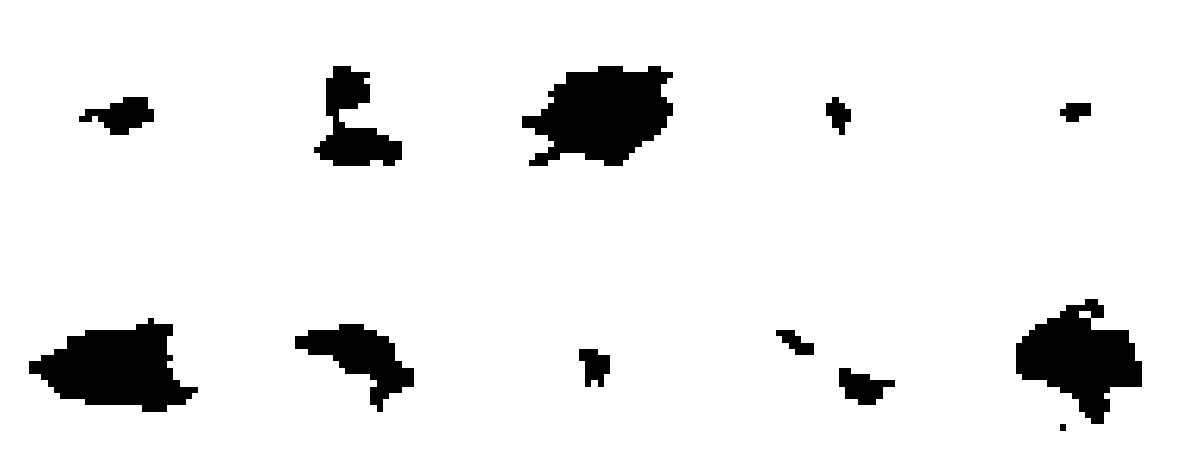

In [7]:
import matplotlib.pyplot as plt


indices = np.random.choice(len(masks_real_train), size=10, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))


for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(masks_real_train[idx], cmap='gray')
    ax.axis('off')
plt.show()


## data generator

In [6]:
import numpy as np
import os
import nibabel as nib
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import os
import nibabel as nib


def get_shapes_and_folders(directory):
    shapes = []
    folders = []


    for dirpath, dirnames, filenames in os.walk(directory):
        if 'ASL' in dirnames:
            target_path = os.path.join(dirpath, 'ASL', 'PD_cal.nii.gz')
            if os.path.exists(target_path):
                img = nib.load(target_path)
                data = img.get_fdata()
                shapes.append(data.shape)
                folders.append(dirpath)

    return shapes, folders


shapes, folders = get_shapes_and_folders('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED_forTraining')
for shape, folder in zip(shapes, folders):
    print(f"Shape: {shape} | Folder: {folder}")



In [25]:
#test
class NiiDataGenerator(Sequence):

    def __init__(self, directory, train_masks, batch_size=16, shuffle=True, split='train', validation_split=0.2, test_split=0.1, augment=False):
        assert split in ['train', 'val', 'test'], "split must be either 'train', 'val', or 'test'"

        self.directory = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.filepaths = self._get_filepaths()
        self.train_masks = train_masks # test code

        num_files = len(self.filepaths)
        val_samples = int(validation_split * num_files)
        test_samples = int(test_split * num_files)
        train_samples = num_files - val_samples - test_samples

        if split == 'train':
            self.filepaths = self.filepaths[:train_samples]
        elif split == 'val':
            self.filepaths = self.filepaths[train_samples:train_samples + val_samples]
        else:  # 'test'
            self.filepaths = self.filepaths[train_samples + val_samples:]

        self.indices = np.arange(len(self.filepaths) * 10 * 5)#
        if self.shuffle:
            np.random.shuffle(self.indices)


        self.augmentor = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')



    def _find_suitable_mask(self, image, max_attempts=300):
        for attempt in range(max_attempts):
            #print(image.shape)#test
            random_masks_index = np.random.choice(self.train_masks.shape[0])
            random_masks = self.train_masks[random_masks_index]
            #print(random_masks.shape)#test
            augmented_masks = self.augmentor.random_transform(random_masks)

            threshold_value = 0.5
            augmented_masks = (augmented_masks > threshold_value).astype(np.float32)

            if image.shape != augmented_masks.shape:
                print("Mismatched shapes! Image shape:", image.shape, "Mask shape:", augmented_masks.shape)
            assert image.shape == augmented_masks.shape, "The shape of the mask must match the shape of the image."
            # assert image.shape[:-1] == mask.shape, "The shape of the mask must match the shape of the image."

            covering_pixels = ((image >= 0.1) & (augmented_masks == 0)).sum()
            target_pixels = (augmented_masks == 0).sum()
            if target_pixels == 0:
                continue
            if covering_pixels / target_pixels >= 0.8:
                return augmented_masks

        raise ValueError("No suitable mask found for given image.")



    @staticmethod
    def random_crop_image(image, crop_size=(32, 32), min_nonzero_ratio=4/5, threshold=0.1, max_attempts=1000):
        attempt_counter = 0
        while  attempt_counter < max_attempts:
            start_x = np.random.randint(0, image.shape[1] - crop_size[0] + 1)
            start_y = np.random.randint(0, image.shape[0] - crop_size[1] + 1)

            cropped = image[start_y:start_y + crop_size[1], start_x:start_x + crop_size[0]]

            if np.count_nonzero(cropped > threshold) / (crop_size[0] * crop_size[1]) >= min_nonzero_ratio:
                return cropped

            attempt_counter += 1

        print("can't find the cropping")




    def _get_filepaths(self):
        filepaths = []
        for dirpath, dirnames, filenames in os.walk(self.directory):
            if 'ASL' in dirnames:
                target_path = os.path.join(dirpath, 'ASL', 'PD_cal.nii.gz')
                if os.path.exists(target_path):
                    filepaths.append(target_path)
        return filepaths

    def __len__(self):
        return int(np.ceil(len(self.filepaths) * 10 * 5 / self.batch_size))#



    def __getitem__(self, index):
        slice_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_filepaths = [self.filepaths[int(i/50)] for i in slice_indices]#
        batch_slice_indices = [i % 10 + 3 for i in slice_indices]#
        X_masked, Masks, X = self._generate_data(batch_filepaths, batch_slice_indices)
        X_expand = np.concatenate([Masks, X], axis=-1)


        return (X_masked, X_expand)





    def _generate_data(self, batch_filepaths, batch_slice_indices):

        X = []
        X_masked = []
        Masks = []

        for filepath, slice_index in zip(batch_filepaths, batch_slice_indices):
            img = nib.load(filepath)
            data = img.get_fdata()

            mean_data_1 = data[..., 5:15]#
            lower, upper = np.percentile(mean_data_1, [1, 99.9])
            norm_data = np.clip(mean_data_1, lower, upper)
            norm_data = (norm_data - lower) / (upper - lower)

            #print("norm_data shape:", norm_data.shape)#test
            sliced_data = norm_data[:, :, slice_index-3][..., np.newaxis]



            for j in range(5):
                cropped_sliced_data = NiiDataGenerator.random_crop_image(sliced_data[..., 0])
                #print(cropped_sliced_data[..., np.newaxis].shape)

                cropped_sliced_data = cropped_sliced_data[..., np.newaxis]
                #print(cropped_sliced_data.shape)


                if self.augment:
                    cropped_sliced_data = self.augmentor.random_transform(cropped_sliced_data)

                suitable_mask = self._find_suitable_mask(cropped_sliced_data)

                masked_data = cropped_sliced_data * suitable_mask

                X.append(cropped_sliced_data)
                X_masked.append(masked_data)
                Masks.append(suitable_mask)




        return np.array(X_masked), np.array(Masks), np.array(X)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [26]:
train_masks = np.expand_dims(masks_real_train, axis=-1)
print(train_masks.shape)

(519, 32, 32, 1)


In [27]:

BATCH_SIZE = 16

train_gen = NiiDataGenerator('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED_forTraining',
                             train_masks=train_masks,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             split='train',
                             augment=True)

val_gen = NiiDataGenerator('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED_forTraining',
                           train_masks=train_masks,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           split='val',
                           augment=False)

test_gen = NiiDataGenerator('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED_forTraining',
                            train_masks=train_masks,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            split='test',
                            augment=False)



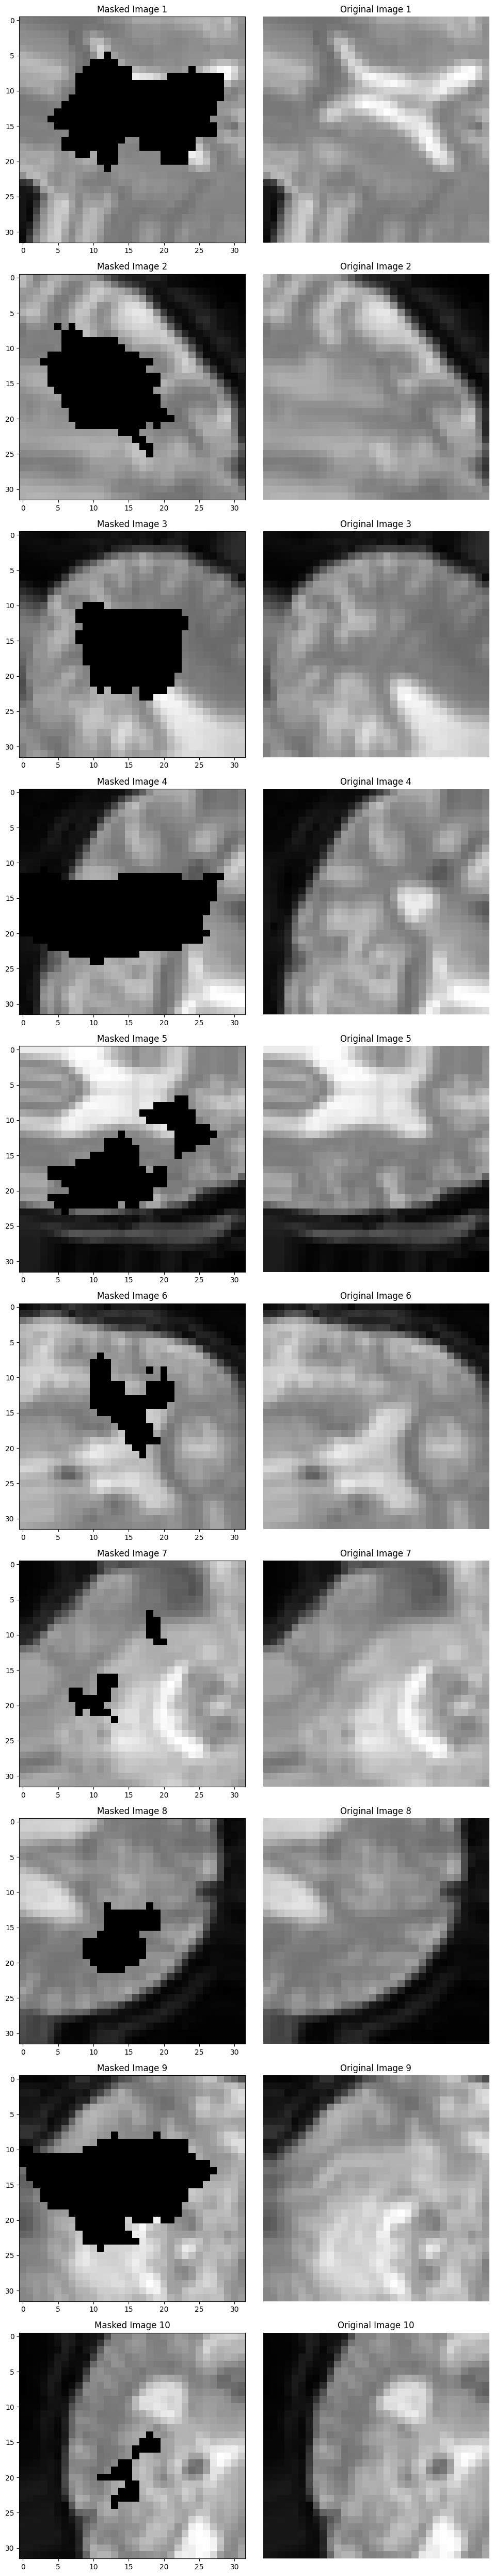

In [ ]:
import matplotlib.pyplot as plt


data_gen = NiiDataGenerator('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED_forTraining', train_masks=train_masks, augment=True, batch_size=32)


(inputs, original_image) = data_gen[0]
masked_images = inputs

num_samples_to_display = 10


fig, axes = plt.subplots(num_samples_to_display, 2, figsize=(10, 5 * num_samples_to_display))

for i in range(num_samples_to_display):
    axes[i, 0].imshow(masked_images[i, :, :], cmap='gray',vmin=0,vmax=1)
    axes[i, 0].set_title(f"Masked Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(original_image[i, :, :], cmap='gray',vmin=0,vmax=1)
    axes[i, 1].set_title(f"Original Image {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Neural Network Part

## Partial convolutional layer

In [28]:

from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        '''

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]


def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

##U-Net

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

from tensorflow.keras.layers import Layer

class RestorationLayer(Layer):
    def __init__(self, **kwargs):
        super(RestorationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        model_output, original_image, mask = inputs

        output_unmasked = model_output * (1 - mask)
        output_masked = original_image * mask
        final_output = output_unmasked + output_masked

        return final_output



def create_model():
    inputs = Input((32, 32, 1))
    # original_image = Input((32, 32, 1))
    # mask = Input((32, 32, 1))


    # encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization(name='encoder_bn1')(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization(name='encoder_bn2')(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization(name='encoder_bn3')(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization(name='encoder_bn4')(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization(name='encoder_bn5')(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization(name='encoder_bn6')(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization(name='encoder_bn7')(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization(name='encoder_bn8')(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # middle
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # decoder
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = Conv2D(512, (3, 3), padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = Conv2D(256, (3, 3), padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = Conv2D(128, (3, 3), padding='same')(up3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = Conv2D(64, (3, 3), padding='same')(up4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)
    # restored_image = RestorationLayer()([conv10, original_image, mask])

    # model = Model(inputs=[inputs, original_image, mask], outputs=[restored_image])
    model = Model(inputs=inputs,outputs=conv10)

    return model

model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 encoder_bn1 (BatchNormalizatio  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 n)                                                                                               
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['encoder_bn1[0][0]']        

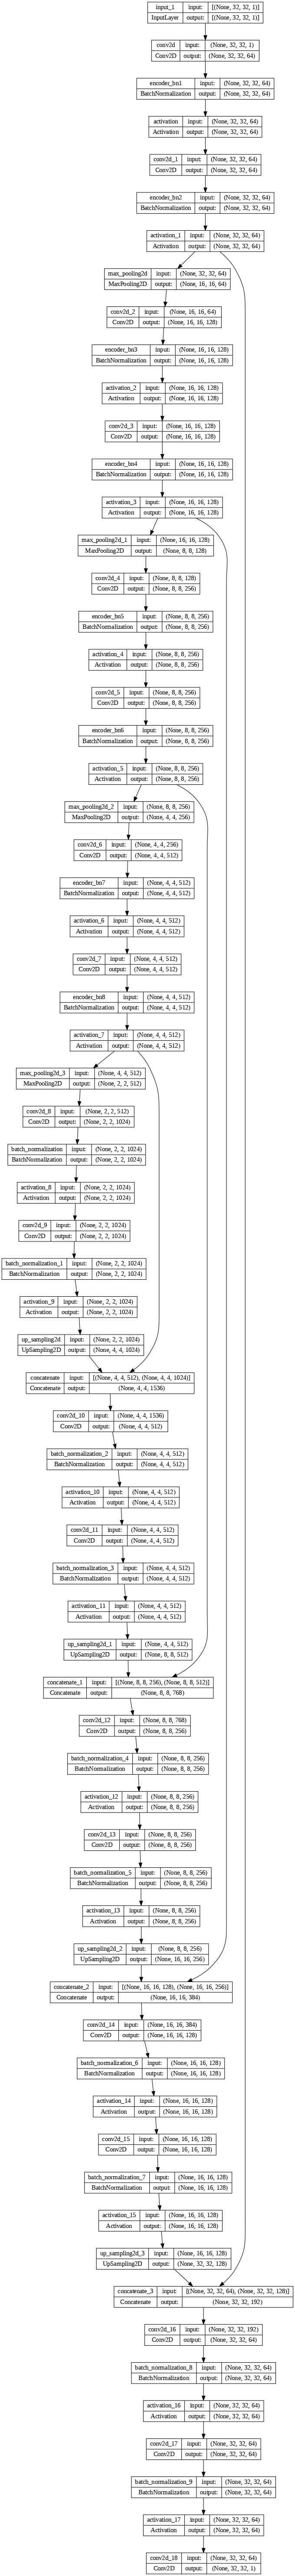

In [13]:
import keras

keras.backend.clear_session()
model.compile(optimizer='adam', loss='mean_absolute_error')
keras.utils.plot_model(model, show_shapes=True, dpi=76)



In [14]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# new_dataset1 = np.expand_dims(new_dataset, axis=-1)
# labels1 = np.expand_dims(labels, axis=-1)
# masks1 = np.expand_dims(masks, axis=-1)

# X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(new_dataset1, labels1, masks1, test_size=0.2, random_state=42)

##PConv U-Net


In [29]:

import keras

class InpaintingModel:

  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,1)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')

    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv16)


    model = keras.models.Model(inputs=[input_image, input_mask], outputs=outputs)
    return model

  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2


## Plot function define

In [30]:
def loss_curve(history):
  plt.figure()
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training Loss and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  #plt.ylim([0,0.01])
  plt.legend()
  plt.show()

## Metrics

In [31]:
def ssim_metrics(y_pred, y_test):
    def calculate_ssim(img1, img2):
        img1 = img_as_float(img1)
        img2 = img_as_float(img2)
        return ssim(img1, img2, channel_axis=0)


    y_pred = y_pred.squeeze()

    y_test_float = y_test.astype('float32')
    y_pred_float = y_pred.astype('float32')



    ssim_values = []
    for i in tqdm(range(len(y_test_float))):
        ssim_values.append(calculate_ssim(y_test_float[i], y_pred_float[i]))

    print('Average SSIM:', np.mean(ssim_values))


## U-Net mse

In [26]:
model_unet_mse = create_model()
optimizer = Adam(learning_rate=0.001)
model_unet_mse.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model_unet_mse.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stop])

history = model_unet_mse.fit(train_gen, validation_data=val_gen, epochs=100, steps_per_epoch=len(train_gen), validation_steps=len(val_gen),callbacks=[early_stop])


Epoch 1/100
23/23 [==============================] - 7s 222ms/step - loss: 0.0232 - val_loss: 0.2725
Epoch 2/100
23/23 [==============================] - 4s 188ms/step - loss: 0.0072 - val_loss: 0.1938
Epoch 3/100
23/23 [==============================] - 4s 187ms/step - loss: 0.0046 - val_loss: 0.1693
Epoch 4/100
23/23 [==============================] - 5s 213ms/step - loss: 0.0040 - val_loss: 0.1500
Epoch 5/100
23/23 [==============================] - 4s 189ms/step - loss: 0.0039 - val_loss: 0.0855
Epoch 6/100
23/23 [==============================] - 4s 195ms/step - loss: 0.0051 - val_loss: 0.0483
Epoch 7/100
23/23 [==============================] - 5s 200ms/step - loss: 0.0042 - val_loss: 0.0476
Epoch 8/100
23/23 [==============================] - 4s 180ms/step - loss: 0.0033 - val_loss: 0.0436
Epoch 9/100
23/23 [==============================] - 4s 180ms/step - loss: 0.0029 - val_loss: 0.0447
Epoch 10/100
23/23 [==============================] - 4s 188ms/step - loss: 0.0028 - val_lo

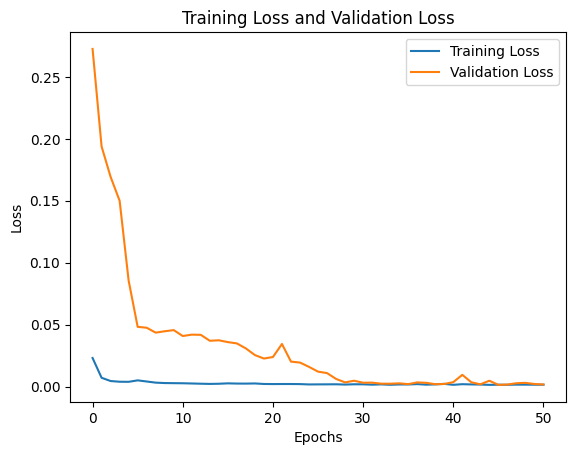

In [27]:
loss_curve(history)

1/1 [==============================] - 1s 1s/step


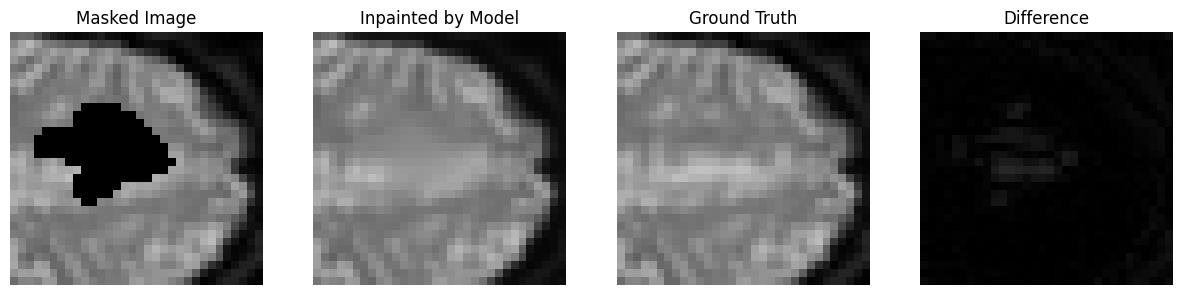

1/1 [==============================] - 0s 19ms/step


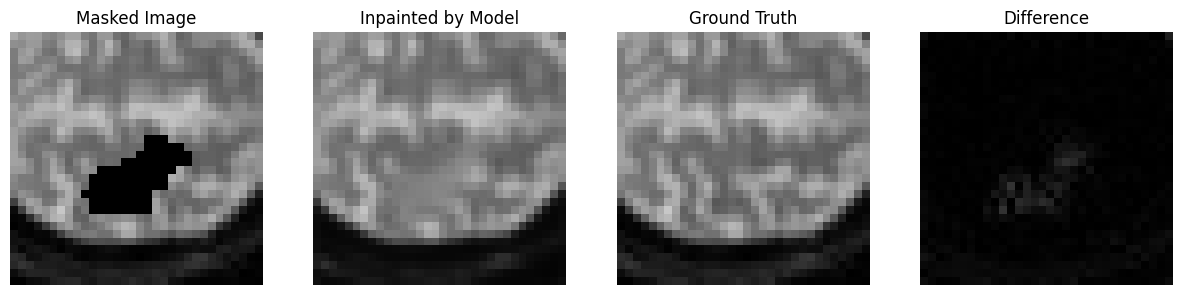

1/1 [==============================] - 0s 19ms/step


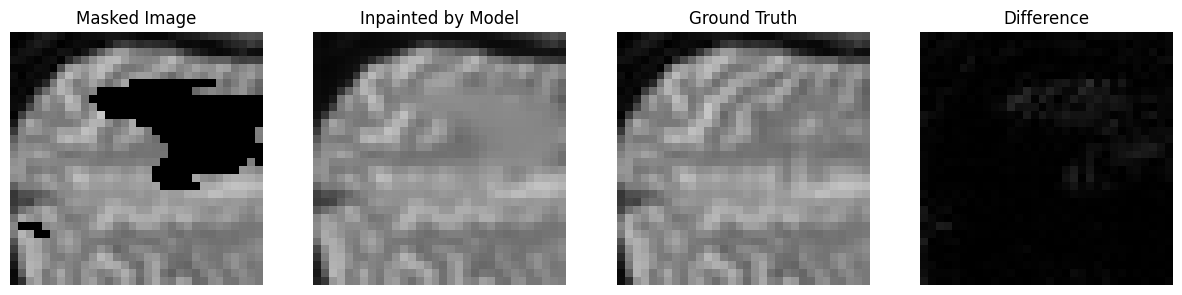

1/1 [==============================] - 0s 19ms/step


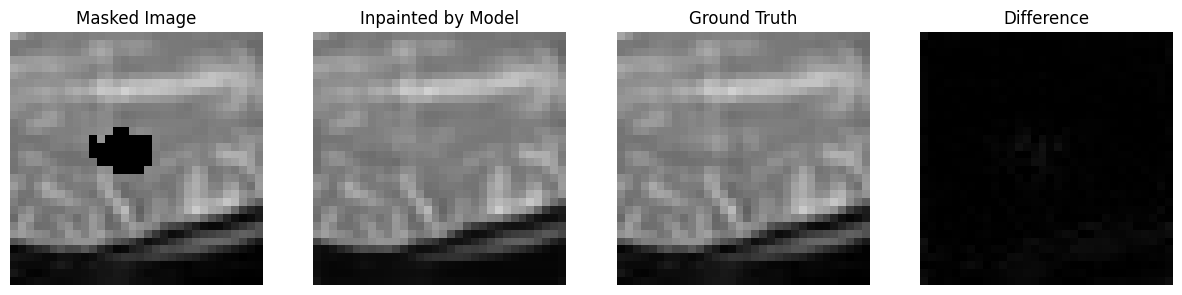

1/1 [==============================] - 0s 20ms/step


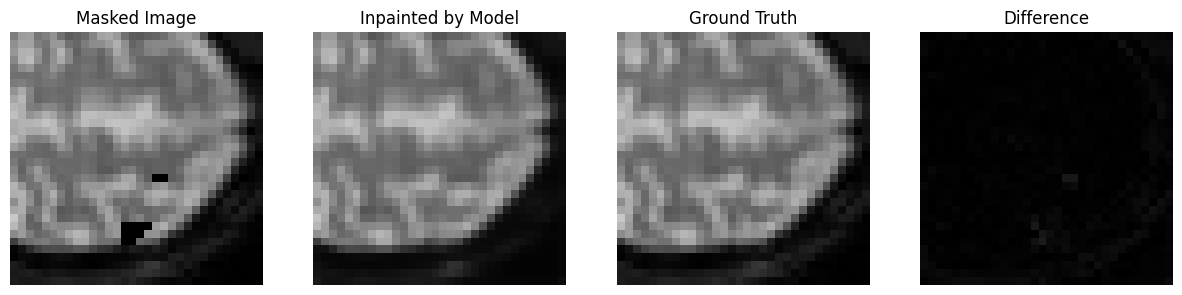

1/1 [==============================] - 0s 18ms/step


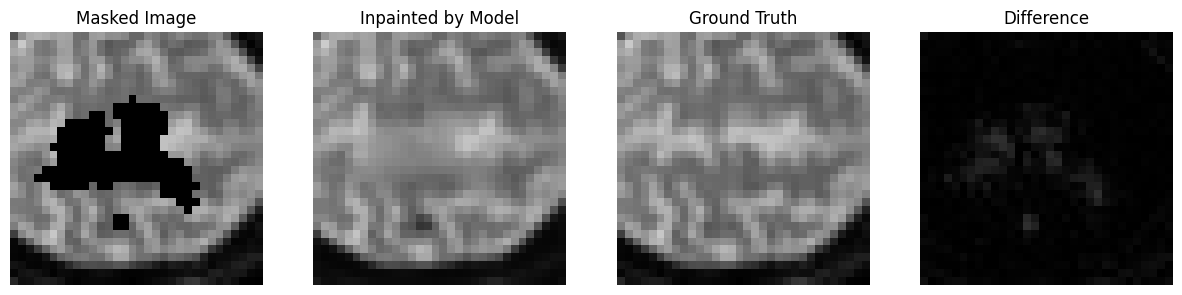

1/1 [==============================] - 0s 19ms/step


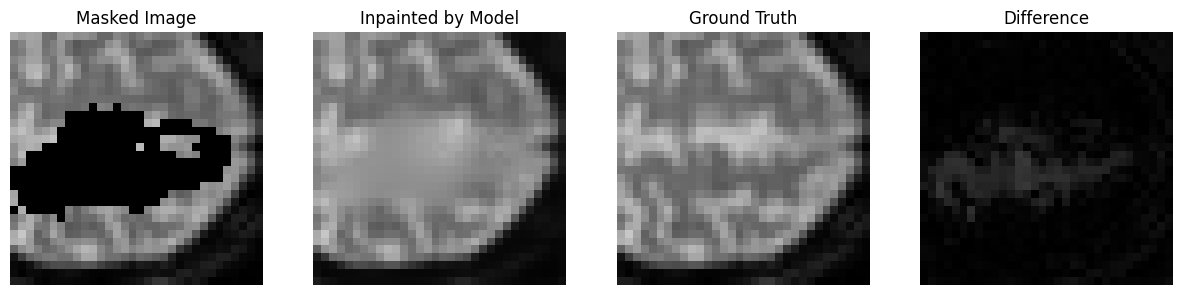

1/1 [==============================] - 0s 19ms/step


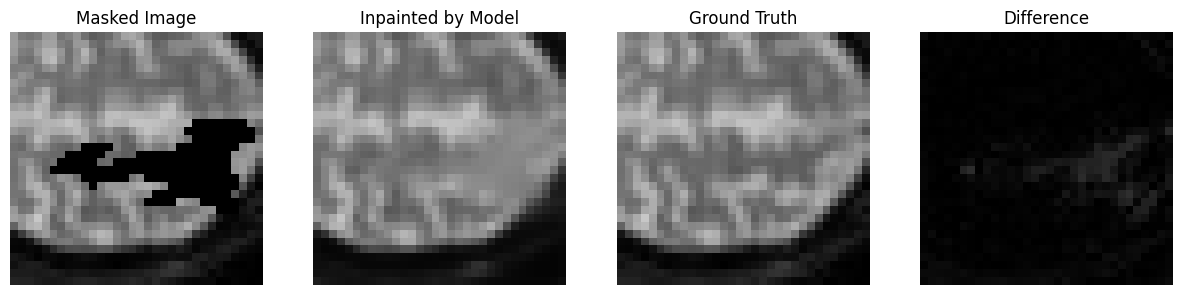

1/1 [==============================] - 0s 19ms/step


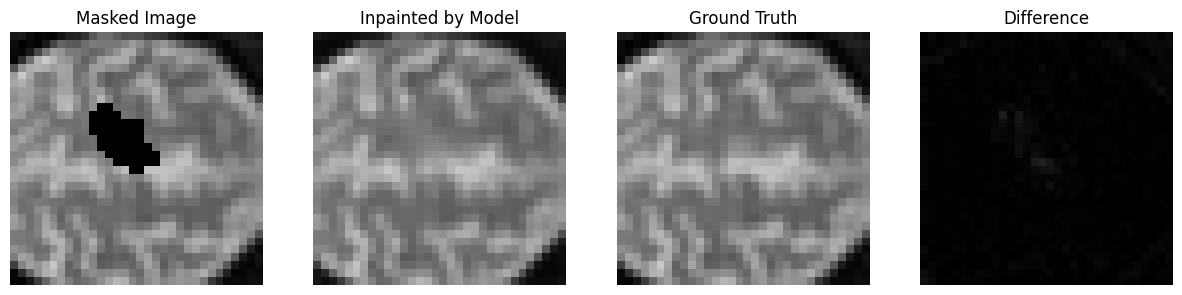

1/1 [==============================] - 0s 19ms/step


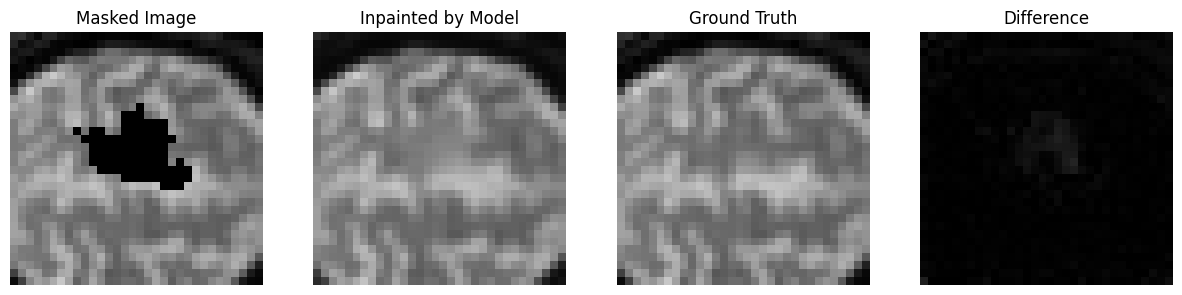

In [28]:
#np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(test_gen))

    (inputs, original_image) = test_gen[img_index]
    original_image_to_display = original_image[0]
    masked_image = inputs[0]
    #mask = inputs[1][0]
    prediction = model_unet_mse.predict([masked_image[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image_to_display.squeeze())

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image_to_display.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()

## Losses

perceptual loss

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load a pre-trained VGG model
vgg = VGG16(include_top=False, weights='imagenet')
loss_model_1 = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_pool').output)
loss_model_1.trainable = False

loss_model_2 = Model(inputs=vgg.input, outputs=vgg.get_layer('block2_pool').output)
loss_model_2.trainable = False

loss_model_3 = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_pool').output)
loss_model_3.trainable = False

# Convert grayscale to RGB
def to_rgb(x):
    return K.concatenate([x, x, x], axis=-1)

def perceptual_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Scale to [0, 255]
    y_true_rgb_scaled = y_true_rgb * 255.0
    y_pred_rgb_scaled = y_pred_rgb * 255.0
    # Preprocess the inputs
    y_true_rgb_preprocessed = preprocess_input(y_true_rgb_scaled)
    y_pred_rgb_preprocessed = preprocess_input(y_pred_rgb_scaled)
    return (1/3)*(K.mean(tf.abs(loss_model_1(y_true_rgb_scaled) - loss_model_1(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_2(y_true_rgb_scaled) - loss_model_2(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_3(y_true_rgb_scaled) - loss_model_3(y_pred_rgb_scaled))))


58889256/58889256 [==============================] - 3s 0us/step


style loss

In [19]:
def gram_matrix(x):
    shape = tf.shape(x)
    batch = shape[0]
    h = shape[1]
    w = shape[2]
    ch = shape[3]
    features = tf.reshape(x, [batch, h * w, ch])
    gram = tf.matmul(features, features, transpose_a=True)
    return gram / tf.cast(ch * w * h, tf.float32)



def style_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Preprocess the images
    y_true_rgb_preprocessed = preprocess_input(y_true_rgb * 255.0)
    y_pred_rgb_preprocessed = preprocess_input(y_pred_rgb * 255.0)
    # Get the VGG features
    y_true_features_1 = loss_model_1(y_true_rgb_preprocessed)
    y_pred_features_1 = loss_model_1(y_pred_rgb_preprocessed)
    y_true_features_2 = loss_model_2(y_true_rgb_preprocessed)
    y_pred_features_2 = loss_model_2(y_pred_rgb_preprocessed)
    y_true_features_3 = loss_model_3(y_true_rgb_preprocessed)
    y_pred_features_3 = loss_model_3(y_pred_rgb_preprocessed)
    # Get the Gram matrices
    y_true_gram_1 = gram_matrix(y_true_features_1)
    y_pred_gram_1 = gram_matrix(y_pred_features_1)
    y_true_gram_2 = gram_matrix(y_true_features_2)
    y_pred_gram_2 = gram_matrix(y_pred_features_2)
    y_true_gram_3 = gram_matrix(y_true_features_3)
    y_pred_gram_3 = gram_matrix(y_pred_features_3)
    # Compute the style loss
    return (1/3)*(K.mean(tf.abs(y_true_gram_1 - y_pred_gram_1)) + K.mean(tf.abs(y_true_gram_2 - y_pred_gram_2)) + K.mean(tf.abs(y_true_gram_3 - y_pred_gram_3)))


tv loss

In [20]:
def tv_loss(y_pred):
    return tf.reduce_sum(tf.image.total_variation(y_pred))

In [21]:
def total_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]

    y_comp = (1-mask)*y_pred + mask*y_true

    return   6*K.mean(tf.abs((1-mask)*(y_true - y_pred))) + K.mean(tf.abs((mask)*(y_true - y_pred))) + 0.05*perceptual_loss(y_true, y_pred) + 0.1*tv_loss(y_pred) + 120*style_loss(y_true,y_pred)


def mse_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]
    return  K.mean(K.square((y_true - y_pred)))


## U-Net combined loss



In [22]:

def total_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]

    y_comp = (1-mask)*y_pred + mask*y_true

    return   6*K.mean(tf.abs((1-mask)*(y_true - y_pred))) + K.mean(tf.abs((mask)*(y_true - y_pred))) + 0.05*perceptual_loss(y_true, y_pred) + 0.1*tv_loss(y_pred) + 120*style_loss(y_true,y_pred)




model_unet_total_loss = create_model()
optimizer = Adam(learning_rate=0.0001)
model_unet_total_loss.compile(optimizer=optimizer, loss=total_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_1 = model_unet_total_loss.fit(train_gen, validation_data=val_gen, epochs=400, steps_per_epoch=len(train_gen), validation_steps=len(val_gen),callbacks=[early_stop])



for layer in model_unet_total_loss.layers:
    if isinstance(layer, keras.layers.BatchNormalization) and 'encoder' in layer.name:
        layer.trainable = False


adam = keras.optimizers.Adam(learning_rate=0.00025)
model_unet_total_loss.compile(optimizer=adam, loss=total_loss)
history_2 = model_unet_total_loss.fit(train_gen, validation_data=val_gen, epochs=300, steps_per_epoch=len(train_gen), validation_steps=len(val_gen),callbacks=[early_stop])

Epoch 1/400
113/113 [==============================] - 67s 392ms/step - loss: 33465.2422 - val_loss: 140731.9219
Epoch 2/400
113/113 [==============================] - 29s 256ms/step - loss: 18927.7754 - val_loss: 131839.3594
Epoch 3/400
113/113 [==============================] - 29s 259ms/step - loss: 16871.1016 - val_loss: 110634.5156
Epoch 4/400
113/113 [==============================] - 30s 262ms/step - loss: 16017.6641 - val_loss: 84137.8516
Epoch 5/400
113/113 [==============================] - 29s 258ms/step - loss: 15302.1670 - val_loss: 60174.9961
Epoch 6/400
113/113 [==============================] - 29s 258ms/step - loss: 14148.1123 - val_loss: 34340.7188
Epoch 7/400
113/113 [==============================] - 29s 258ms/step - loss: 14278.2236 - val_loss: 18194.8066
Epoch 8/400
113/113 [==============================] - 29s 258ms/step - loss: 13913.7607 - val_loss: 17813.0547
Epoch 9/400
113/113 [==============================] - 29s 259ms/step - loss: 13410.7305 - val_loss: 

In [24]:
# model_path = "/content/drive/MyDrive/Colab Notebooks/thesis/network/model_unet_total_loss_dg.h5"
# model_unet_total_loss.save(model_path)

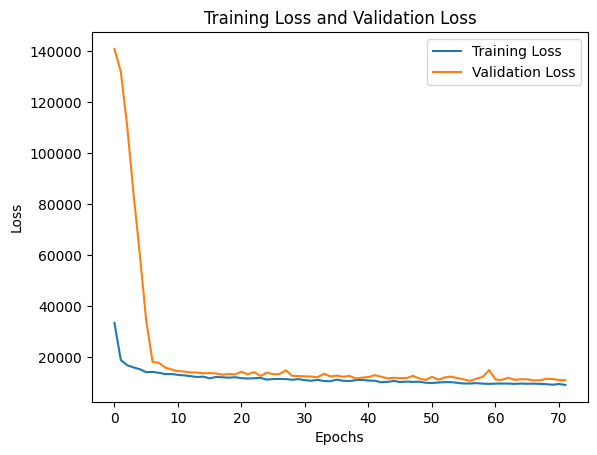

In [32]:
loss_curve(history_1)

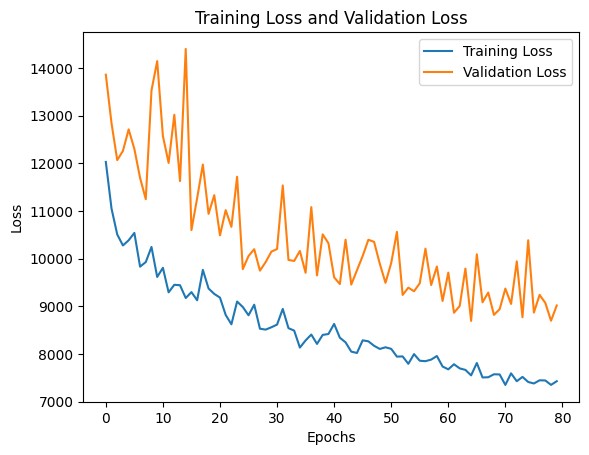

In [33]:
loss_curve(history_2)

##PConv U-Net combined loss

### Train

In [34]:
def total_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]

    y_comp = (1-mask)*y_pred + mask*y_true

    return   6*K.mean(tf.abs((1-mask)*(y_true - y_pred))) + K.mean(tf.abs((mask)*(y_true - y_pred))) + 0.05*perceptual_loss(y_true, y_pred) + 0.1*tv_loss(y_pred) + 120*style_loss(y_true,y_pred)


def mse_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]
    return  K.mean(K.square((y_true - y_pred)))

# input_img = keras.layers.Input((32,32,1))
# input_mask = keras.layers.Input((32,32,1))


inpainting_model = InpaintingModel()

model_pconv_total_loss = inpainting_model.prepare_model()

adam = keras.optimizers.Adam(learning_rate=0.0001)
model_pconv_total_loss.compile(optimizer=adam, loss=total_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

#history_1 = model_pconv_total_loss.fit([X_train_expand, masks_train_expand], y_train_concat, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])
history_1 = model_pconv_total_loss.fit(train_gen, validation_data=val_gen, epochs=400, steps_per_epoch=len(train_gen), validation_steps=len(val_gen),callbacks=[early_stop])


for layer in model_pconv_total_loss.layers:
    if isinstance(layer, keras.layers.BatchNormalization) and 'encoder' in layer.name:
        layer.trainable = False


adam = keras.optimizers.Adam(learning_rate=0.000025)
model_pconv_total_loss.compile(optimizer=adam, loss=total_loss)
#history_2 = model_pconv_total_loss.fit([X_train_expand, masks_train_expand], y_train_concat, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])
history_2 = model_pconv_total_loss.fit(train_gen, validation_data=val_gen, epochs=400, steps_per_epoch=len(train_gen), validation_steps=len(val_gen),callbacks=[early_stop])

Epoch 1/400
113/113 [==============================] - 40s 290ms/step - loss: 121417.3594 - val_loss: 145842.4375
Epoch 2/400
113/113 [==============================] - 30s 267ms/step - loss: 117641.6016 - val_loss: 145439.6094
Epoch 3/400
113/113 [==============================] - 31s 272ms/step - loss: 101578.7734 - val_loss: 142843.6562
Epoch 4/400
113/113 [==============================] - 30s 269ms/step - loss: 88637.0703 - val_loss: 137852.4375
Epoch 5/400
113/113 [==============================] - 31s 273ms/step - loss: 69172.1172 - val_loss: 114087.2578
Epoch 6/400
113/113 [==============================] - 30s 265ms/step - loss: 58942.7344 - val_loss: 82444.6562
Epoch 7/400
113/113 [==============================] - 30s 267ms/step - loss: 50644.9688 - val_loss: 62352.8516
Epoch 8/400
113/113 [==============================] - 31s 270ms/step - loss: 41525.1289 - val_loss: 54321.6836
Epoch 9/400
113/113 [==============================] - 30s 266ms/step - loss: 37911.9844 - val_l

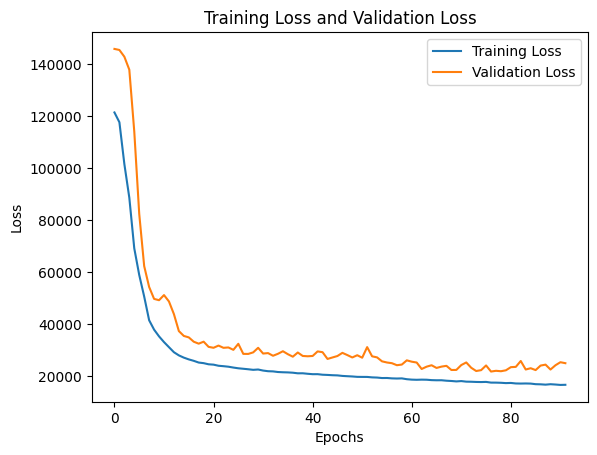

In [35]:
loss_curve(history_1)

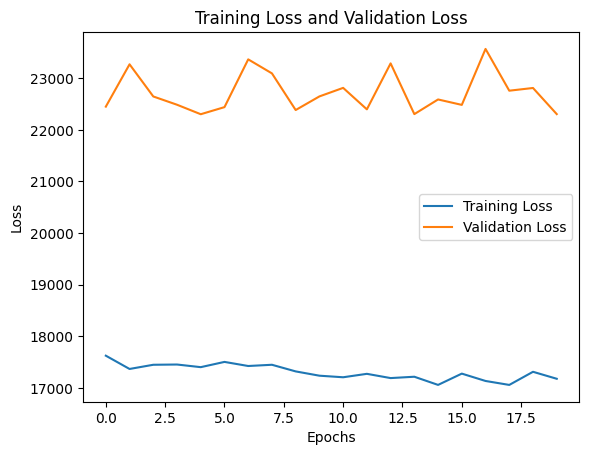

In [36]:
loss_curve(history_2)

1/1 [==============================] - 1s 1s/step


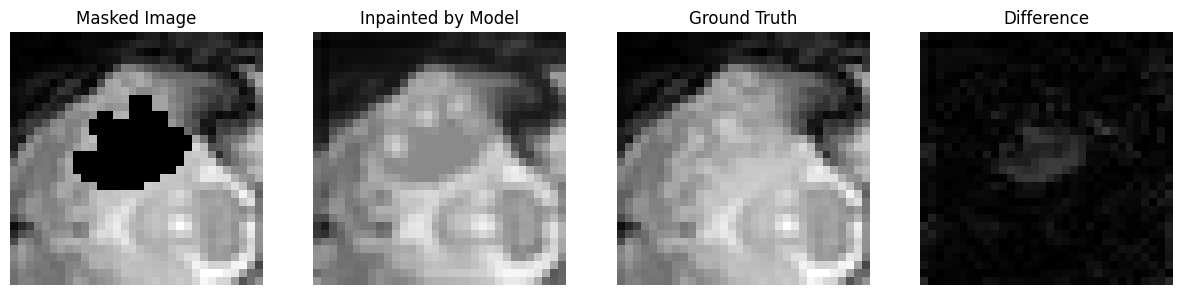

1/1 [==============================] - 0s 24ms/step


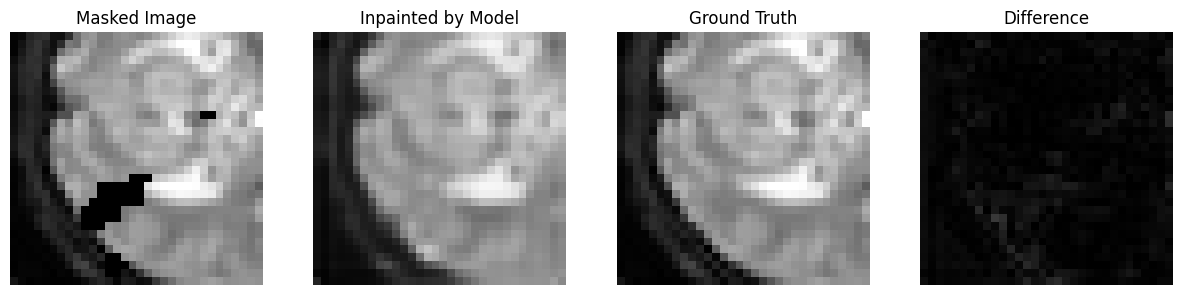

1/1 [==============================] - 0s 24ms/step


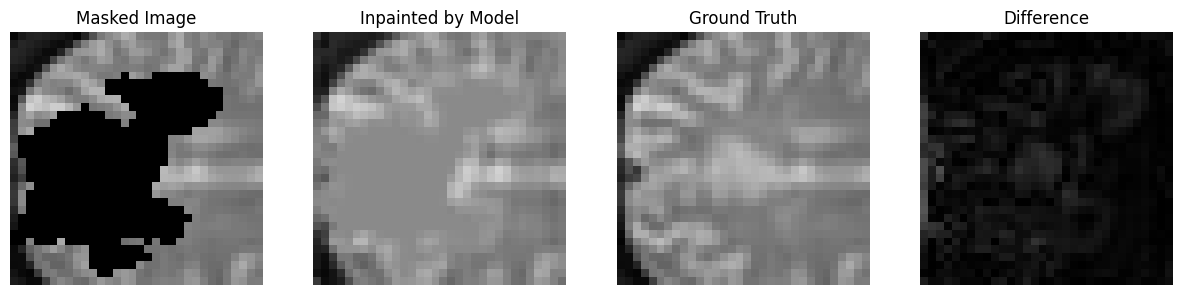

1/1 [==============================] - 0s 27ms/step


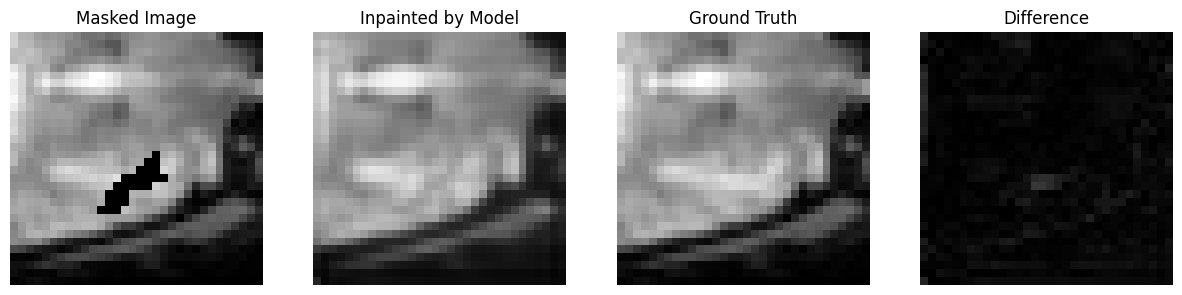

1/1 [==============================] - 0s 26ms/step


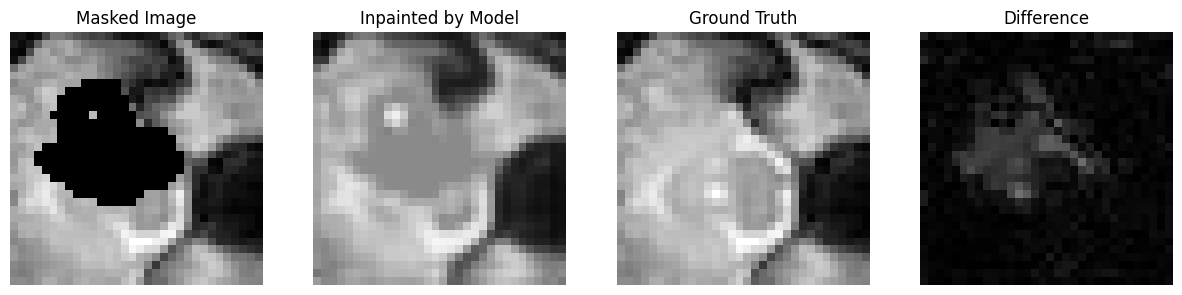

1/1 [==============================] - 0s 24ms/step


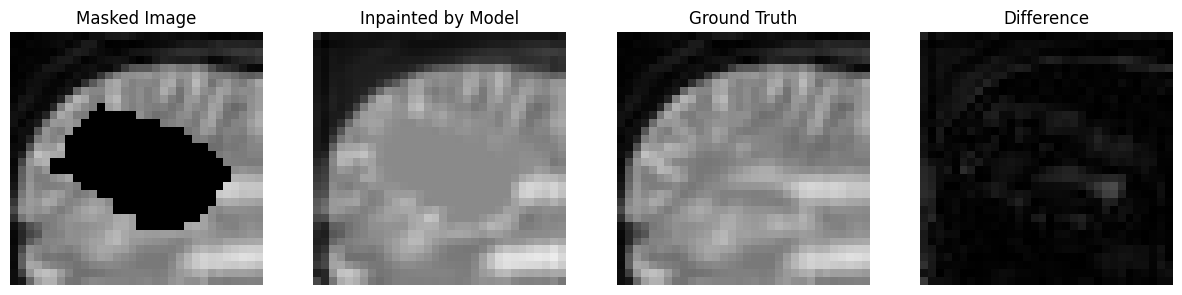

1/1 [==============================] - 0s 28ms/step


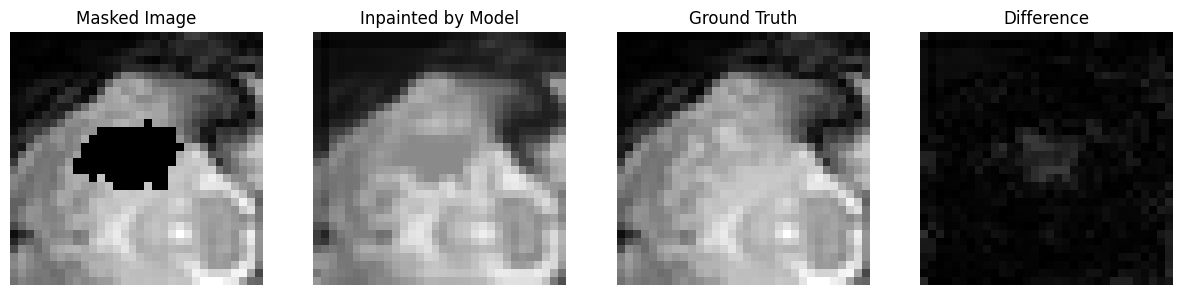

1/1 [==============================] - 0s 24ms/step


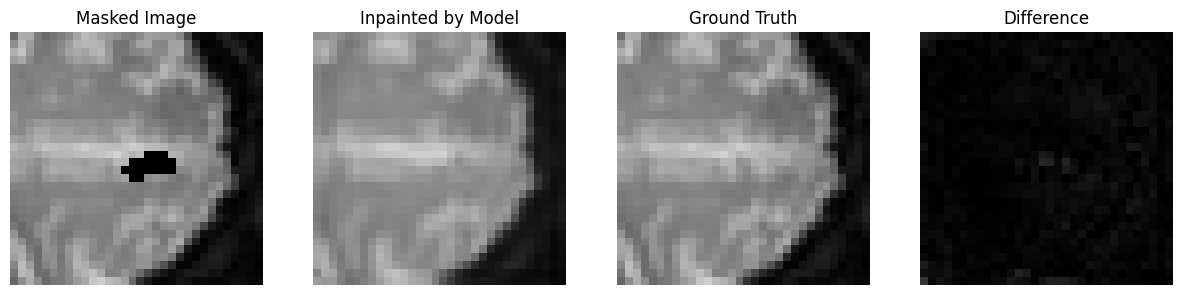

1/1 [==============================] - 0s 22ms/step


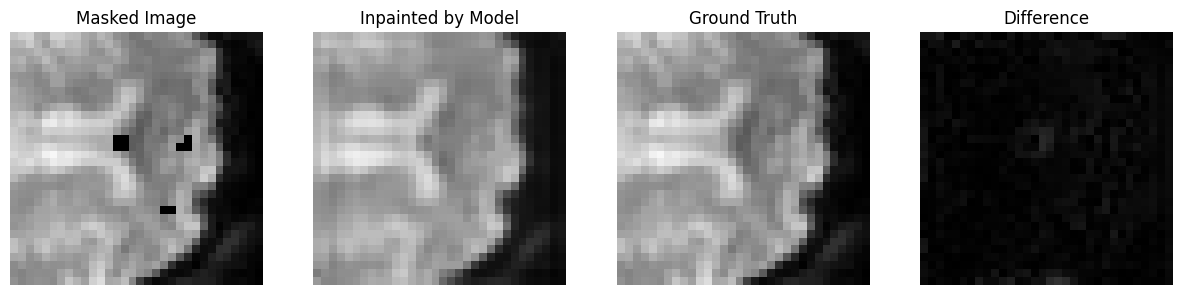

1/1 [==============================] - 0s 23ms/step


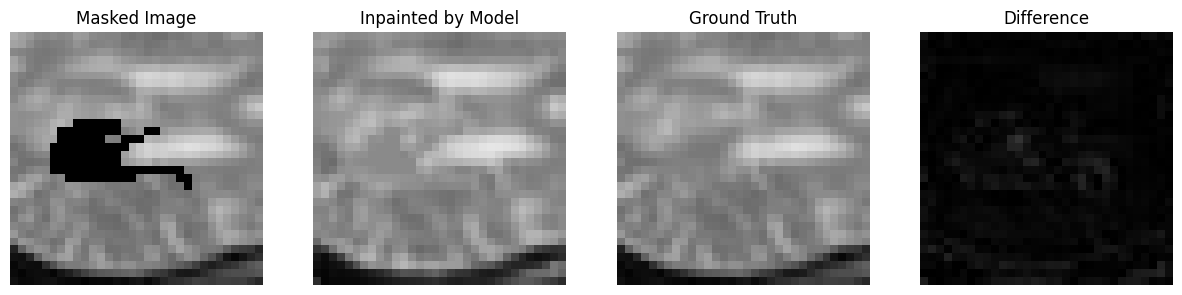

In [37]:
#np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(test_gen))

    (inputs, original_image) = test_gen[img_index]
    original_image_to_display = original_image[0][...,1:]
    masked_image = inputs[0][0]
    mask = inputs[1][0]
    prediction = model_pconv_total_loss.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image_to_display.squeeze())

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image_to_display.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()